# Data Preprocessing

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.metrics import Recall, Precision

In [2]:
#Check GPU device available
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Load dataset
data_train = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
data_test = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [6]:
# Handle missing value and duplicate if any
data_train.dropna(inplace=True)
data_train.drop_duplicates(inplace=True)

data_test.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)

In [7]:
#Split Attack and Normal from dataframe
data_train_attack = data_train[data_train['label'] == 1]
data_test_attack = data_test[data_test['label'] == 1]

#Optional
#data_train_normal = data_train[data_train['label'] == 0]
#data_test_normal = data_test[data_test['label'] == 0]

In [8]:
# Drop id and label from train and test data
data_train_attack = data_train_attack.drop('id', axis=1)
data_train_attack = data_train_attack.drop('label', axis=1)

data_test_attack = data_test_attack.drop('id', axis=1)
data_test_attack = data_test_attack.drop('label', axis=1)

In [9]:
print(data_train_attack['state'].nunique())
print(data_test_attack['state'].nunique())

6
5


In [10]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'ACC' 'CON' 'REQ' 'CLO']
['INT' 'FIN' 'CON' 'REQ' 'RST']


In [11]:
#Drop ACC, CLO, and RST from data
data_train_attack = data_train_attack[(data_train_attack['state'] != 'ACC') & (data_train_attack['state'] != 'CLO')]
data_test_attack = data_test_attack[(data_test_attack['state'] != 'RST')]

In [12]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ']
['INT' 'FIN' 'CON' 'REQ']


## Encode Train and Test Data

In [13]:
#column to encode
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [14]:
#One-hot Encoding
# Encode train data
data_train_attack = pd.get_dummies(data_train_attack, columns=cols)

# Encode test data
data_test_attack = pd.get_dummies(data_test_attack, columns=cols)

In [15]:
train_attack_cat = data_train_attack.pop('attack_cat')
test_attack_cat = data_test_attack.pop('attack_cat')

## Normalization

In [16]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_norm = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 
                'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 
                'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 
                'ct_srv_dst', 'is_sm_ips_ports']

data_train_attack[cols_to_norm] = scaler.fit_transform(data_train_attack[cols_to_norm])
data_test_attack[cols_to_norm] = scaler.fit_transform(data_test_attack[cols_to_norm])

## Feature Selection

In [17]:
#Feature Selection
feature = data_train_attack.drop(['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'], axis=1)
feature.dtypes

dur               float64
spkts             float64
dpkts             float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 181, dtype: object

# Initialize Train Data and Test Data

In [18]:
#Splitting the dataset into dependent and independent feature
X_train = feature
y_train = train_attack_cat

X_test = data_test_attack.drop(columns=['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'])
y_test = test_attack_cat

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45329, 181), (45329,), (119329, 181), (119329,))

# Model Architecture

In [1]:
# from keras import backend as K
import tensorflow_addons as tfa

c:\Users\Acer\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Acer\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [19]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

## 1D-CNN (1 layer) Model

In [20]:
# Define the input shape
input_shape = (181, 1)

# Create the sequential model
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=32, kernel_size=5, activation='sigmoid', input_shape=input_shape))

# MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2, strides=1))

# Flatten layer
model.add(Flatten())

# Batch Normalization layer
model.add(BatchNormalization(axis=-1))

# Dropout layer with dropout 0.5
model.add(Dropout(0.5))

# Two Fully-connected layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output
model.add(Dense(units=9, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision(), tfa.metrics.F1Score(num_classes=9, 
                                                                                                                                 average='macro')])

In [21]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 177, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5632)              0         
                                                                 
 batch_normalization (BatchN  (None, 5632)             22528     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5632)              0         
                                                                 
 dense (Dense)               (None, 32)                1

## Train the model

In [20]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [22]:
num_class = 9
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [23]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [26]:
#Define epochs and batch size
epochs = 50
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
1417/1417 [==============================] - 29s 18ms/step - loss: 0.7141 - accuracy: 0.7391 - recall: 0.6328 - precision: 0.8889 - f1_score: 0.3465 - val_loss: 0.7343 - val_accuracy: 0.7380 - val_recall: 0.6120 - val_precision: 0.8810 - val_f1_score: 0.3655
Epoch 2/50
1417/1417 [==============================] - 27s 19ms/step - loss: 0.6195 - accuracy: 0.7648 - recall: 0.6688 - precision: 0.8913 - f1_score: 0.3735 - val_loss: 0.7430 - val_accuracy: 0.7207 - val_recall: 0.6167 - val_precision: 0.8636 - val_f1_score: 0.3693
Epoch 3/50
1417/1417 [==============================] - 27s 19ms/step - loss: 0.6021 - accuracy: 0.7694 - recall: 0.6765 - precision: 0.8927 - f1_score: 0.3799 - val_loss: 0.7475 - val_accuracy: 0.7364 - val_recall: 0.6117 - val_precision: 0.8733 - val_f1_score: 0.3543
Epoch 4/50
1417/1417 [==============================] - 27s 19ms/step - loss: 0.5939 - accuracy: 0.7692 - recall: 0.6785 - precision: 0.8950 - f1_score: 0.3834 - val_loss: 0.7628 - val_accur

## Evaluate The Model

In [25]:
#Evaluate the model on test data
loss, accuracy, recall, precision, f1_score = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Recall:', recall)
print('Test Precision:', precision)
print('Test F1-Score:', f1_score)

3730/3730 [==============================] - 21s 6ms/step - loss: 0.7297 - accuracy: 0.7630 - recall: 0.6464 - precision: 0.8928 - f1_score: 0.4493
Test Loss: 0.7297492027282715
Test Accuracy: 0.7629997730255127
Test Recall: 0.6464145183563232
Test Precision: 0.8928087949752808
Test F1-Score: 0.7498906262523612


In [28]:
# make a predictions
predictions = model.predict(X_test)

3730/3730 [==============================] - 6s 2ms/step


In [29]:
# convert one-hot encode predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

### Confusion Matrix

In [30]:
# function to calculate recall from confusion matrix
def calculate_recall(confusion_matrix):
    num_class = len(confusion_matrix)
    recalls = []

    for i in range(num_class):
        true_positive = confusion_matrix[i][i]
        false_negative = sum(confusion_matrix[i]) - true_positive

        recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
    
    return recalls

In [31]:
# function to display the recall score
def display_recall(recalls):
    print('Recall Scores for each class:')
    print('Analysis:', recalls[0])
    print('Backdoor:', recalls[1])
    print('DoS:', recalls[2])
    print('Exploits:', recalls[3])
    print('Fuzzers:', recalls[4])
    print('Generic:', recalls[5])
    print('Reconnaissance:', recalls[6])
    print('Shellcode:', recalls[7])
    print('Worms:', recalls[8])

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
matrix = confusion_matrix(y_test_categorical, predicted_classes)
matrix_df = pd.DataFrame(matrix, 
                         index= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'], 
                         columns= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'])

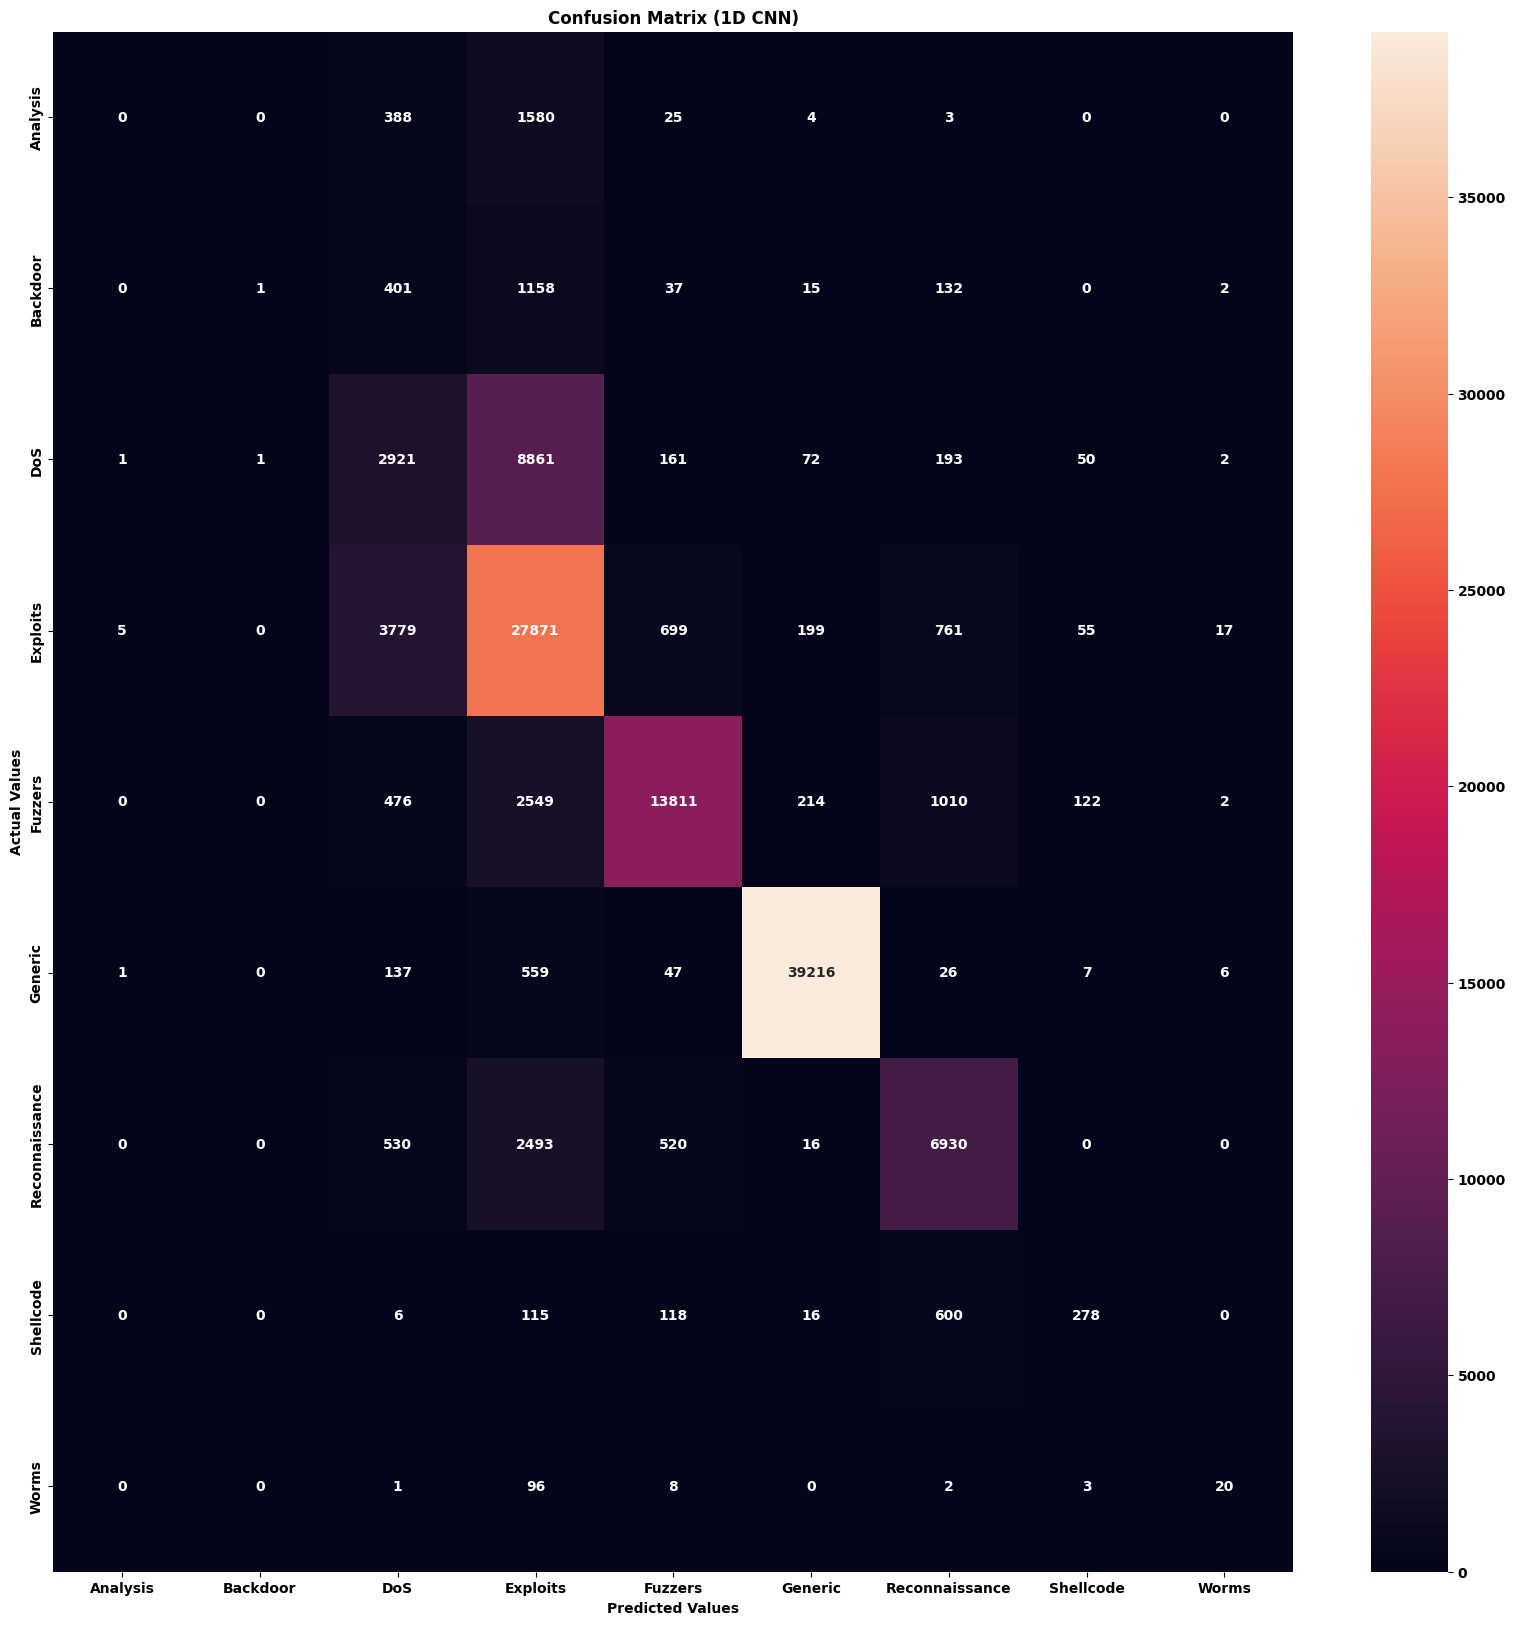

In [34]:
# Plotting Confusion Matrix
plt.figure(figsize = (20, 20))
sns.heatmap(matrix_df, fmt='.0f', annot=True)
plt.title('Confusion Matrix (1D CNN)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [35]:
recalls = calculate_recall(matrix)
display_recall(recalls)

Recall Scores for each class:
Analysis: 0.0
Backdoor: 0.000572737686139748
DoS: 0.2382156255097048
Exploits: 0.834810998622177
Fuzzers: 0.7595138583369996
Generic: 0.9804245106127654
Reconnaissance: 0.6606921536848127
Shellcode: 0.24536628420123566
Worms: 0.15384615384615385


## Save and load the model

In [2]:
from keras.models import load_model

In [37]:
# save the 1D CNN trained model using keras
model.save('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/GPU_Saved/CNN_2/cnn1d.keras')

In [3]:
# load the 1D CNN trained model using keras
model = load_model('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/GPU_Saved/CNN_2/cnn1d.keras')

## Save and load the predicted

In [39]:
import pickle

In [40]:
# save the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/GPU_Saved/CNN_2/predicted_classes.pkl', 'wb') as model_file:
    pickle.dump(predicted_classes, model_file)

In [41]:
# load the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/GPU_Saved/CNN_2/predicted_classes.pkl', 'rb') as model_file:
    predicted_classes = pickle.load(model_file)